<h1>Détection des defauts dans les centrales solaires</h1>

Ce Notebook accompagne un projet Kaggle au sujet de la génération d'électricité solaire.<br>
Veuillez trouver les données ici: https://www.kaggle.com/anikannal/solar-power-generation-data<br>
Les données présentent une bonne opportunité de comprendre plus sur les technologies solaires, et les facteurs qui influencent leur efficacité. Dans ce Notebook, je montre une application simple de Linear Régression pour identifier les défauts potentiels dans une centrale composée de plusiers cellules photovoltaiques.<br>

D'abord, on doit importer les modules Python:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression

Ensuite, j'organise les données et je les range un peu.

In [2]:
data_dir = "~/projects/solar/archive/"
plant_names = ['Plant_1', 'Plant_2']
datasets = {}

for plant_name in plant_names:
    power_data = pd.read_csv(data_dir + plant_name + "_Generation_Data.csv")
    weather_data = pd.read_csv(data_dir + plant_name + "_Weather_Sensor_Data.csv")
    
    # rename unclear columns "SOURCE_KEY_x" and "SOURCE_KEY_y"
    power_data = power_data.rename(columns={"SOURCE_KEY": "INVERTER_ID"})
    weather_data = weather_data.rename(columns={"SOURCE_KEY": "WEATHER_SENSOR_ID"})

    # fix timestamps, as the two power datasets have inconsistent formats
    # YYYY-MM-DD HH:MM:SS
    if power_data['DATE_TIME'][0].index("-") == 2:
        power_data['DATE_TIME'] = pd.to_datetime(power_data['DATE_TIME'], dayfirst=True)
    else:
        power_data['DATE_TIME'] = pd.to_datetime(power_data['DATE_TIME'], yearfirst=True)

    if weather_data['DATE_TIME'][0].index("-") == 2:
        weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'], dayfirst=True)
    else:
        weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'], yearfirst=True)

    power_data['DATE_TIME'] = pd.to_datetime(power_data['DATE_TIME'], dayfirst=True)
    weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'], yearfirst=True)

    # merge data tables together for each plant
    data = power_data.merge(weather_data, on=['DATE_TIME','PLANT_ID'], how='left')

    data['DATE'] = data['DATE_TIME'].dt.date
    data['TIME'] = data['DATE_TIME'].dt.time

    if len(data['PLANT_ID'].unique()) != 1:
        print('error with plant ids')
        pdb.set_trace()

    plant_id = data['PLANT_ID'][0]
    datasets[plant_name] = data

Je fais un graphique basique pour visualiser les données.

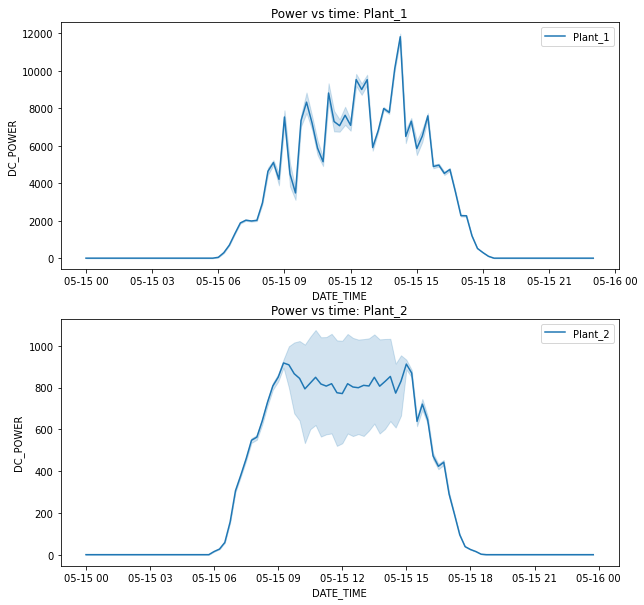

In [3]:
i = 211
plt.figure(figsize=(10,10))

for plant_name in plant_names:
    data = datasets[plant_name]
    data_subset = data.loc[data['DATE'] == data['DATE'][0]]
    
    plt.subplot(i)
    sns.lineplot(x="DATE_TIME", y="DC_POWER", label=plant_name, data=data_subset)
    plt.title('Power vs time: {}'.format(plant_name))
    i+=1

plt.show()

Ensuite, explorons les données pour établir comment on pourrait identifier des défauts.
C'est clair qu'on peut anticiper un lien fort entre l'électricité génerée et l'irradiation solaire.
Donc, si il y a des occasions dans lesquelles la quantité d'électricité génerée diffère considérablement de la quantité anticipée, on peut étre confiant que quelque chose mérite plus d'attention.

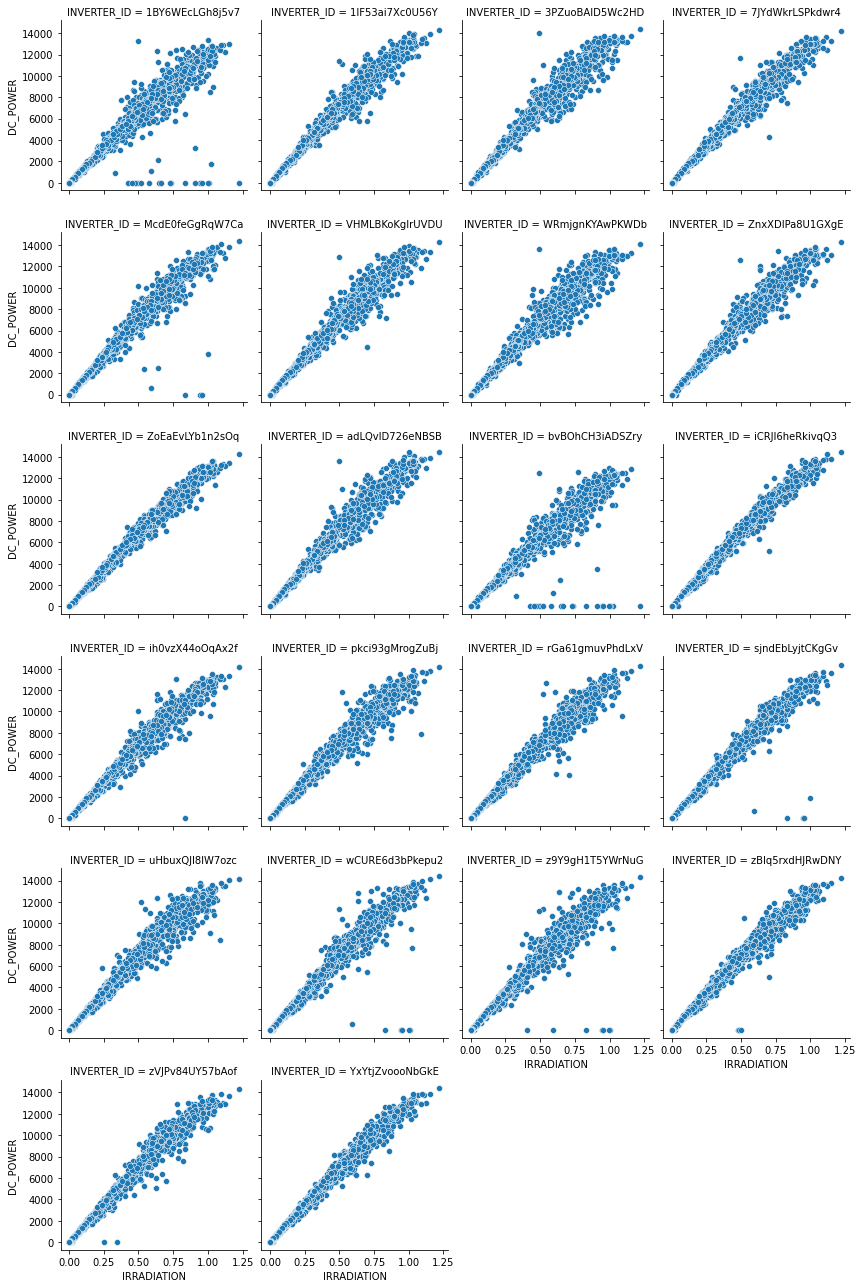

In [4]:
# investigate link between power and solar irradiance to spot faults for each inverter
Plant_1 = datasets['Plant_1']
g = sns.FacetGrid(data=Plant_1, col="INVERTER_ID", col_wrap=4, height=3)
g.map(sns.scatterplot, "IRRADIATION", "DC_POWER")
plt.show()

Comme anticipé, il y a une correlation forte entre l'irradiation et l'électricité génerée. Il y a aussi des instances avec des comportements qui suggèrent une malfunction, par exemple quand il y a plein d'irradiation et l'électricité génerée est ~0.

In [5]:
anomalies = Plant_1.loc[(Plant_1['DC_POWER']<1000) & (Plant_1['IRRADIATION']>0.25)]
anomalies

,DATE_TIME,PLANT_ID,INVERTER_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,WEATHER_SENSOR_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME
815,2020-05-15 09:15:00,4135001,zVJPv84UY57bAof,0.0,0.0,711.0,7116862.0,HmiyD2TTLFNqkNe,27.988362,46.617706,0.344884,2020-05-15,09:15:00
18490,2020-05-24 15:15:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,6464.0,6410945.0,HmiyD2TTLFNqkNe,33.761304,54.006864,0.476600,2020-05-24,15:15:00
20103,2020-05-25 10:15:00,4135001,ih0vzX44oOqAx2f,0.0,0.0,1795.0,6258289.0,HmiyD2TTLFNqkNe,29.217751,53.501414,0.834157,2020-05-25,10:15:00
46679,2020-06-07 12:15:00,4135001,bvBOhCH3iADSZry,0.0,0.0,3551.0,6476675.0,HmiyD2TTLFNqkNe,28.748334,59.987771,1.024229,2020-06-07,12:15:00
46690,2020-06-07 12:30:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,3634.0,6422116.0,HmiyD2TTLFNqkNe,28.884908,59.149143,1.006504,2020-06-07,12:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61595,2020-06-14 13:45:00,4135001,bvBOhCH3iADSZry,0.0,0.0,2378.0,6520020.0,HmiyD2TTLFNqkNe,27.048904,47.960231,0.906615,2020-06-14,13:45:00
61606,2020-06-14 14:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,2402.0,6466065.0,HmiyD2TTLFNqkNe,27.848916,59.386079,1.221652,2020-06-14,14:00:00
61617,2020-06-14 14:00:00,4135001,bvBOhCH3iADSZry,0.0,0.0,2378.0,6520020.0,HmiyD2TTLFNqkNe,27.848916,59.386079,1.221652,2020-06-14,14:00:00
65718,2020-06-16 12:30:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,3480.0,6575313.0,HmiyD2TTLFNqkNe,27.964037,45.408554,0.483400,2020-06-16,12:30:00


On va essayer un analyse basique et statistique de Linear Regression, avec les données de Plant_1.
Il faut trouver les anomalies dans une manière un peu plus "scientifique".

D'abord, un peu de nettoyage pour éliminer les NaNs et reformatter les données pour qu'elles deviennent compatibles avec le Linear Regression fonction de scikit-learn.

In [6]:
Plant_1 = Plant_1.loc[np.isnan(Plant_1['IRRADIATION'])==False]
Plant_1 = Plant_1.reset_index(drop=True)

In [7]:
x = np.array(Plant_1['IRRADIATION']).reshape((-1, 1))
y = np.array(Plant_1['DC_POWER'])

In [8]:
model = LinearRegression().fit(x, y)

In [9]:
r_sq = model.score(x, y)
print(r_sq)

0.9788946317890934


In [10]:
print(model.coef_)
print(model.intercept_)

[13226.20218138]
74.66409208708092


In [11]:
power_predict = Plant_1['IRRADIATION']*model.coef_[0] + model.intercept_
power_predict = [i for i in power_predict]

In [12]:
Plant_1['DC_POWER_PREDICT'] = power_predict
Plant_1['DC_POWER_PREDICT']

0        74.664092
1        74.664092
2        74.664092
3        74.664092
4        74.664092
           ...    
68769    74.664092
68770    74.664092
68771    74.664092
68772    74.664092
68773    74.664092
Name: DC_POWER_PREDICT, Length: 68774, dtype: float64

In [13]:
Plant_1.loc[Plant_1['DC_POWER'] != 0]

,DATE_TIME,PLANT_ID,INVERTER_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,WEATHER_SENSOR_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DC_POWER_PREDICT
510,2020-05-15 06:00:00,4135001,1BY6WEcLGh8j5v7,37.142857,3.585714,0.000000,6259559.000,HmiyD2TTLFNqkNe,24.088446,22.206757,0.005887,2020-05-15,06:00:00,152.526178
511,2020-05-15 06:00:00,4135001,1IF53ai7Xc0U56Y,53.500000,5.162500,0.000000,6183645.000,HmiyD2TTLFNqkNe,24.088446,22.206757,0.005887,2020-05-15,06:00:00,152.526178
512,2020-05-15 06:00:00,4135001,3PZuoBAID5Wc2HD,58.000000,5.585714,0.000000,6987759.000,HmiyD2TTLFNqkNe,24.088446,22.206757,0.005887,2020-05-15,06:00:00,152.526178
513,2020-05-15 06:00:00,4135001,7JYdWkrLSPkdwr4,58.428571,5.628571,0.000000,7602960.000,HmiyD2TTLFNqkNe,24.088446,22.206757,0.005887,2020-05-15,06:00:00,152.526178
514,2020-05-15 06:00:00,4135001,McdE0feGgRqW7Ca,54.375000,5.250000,0.000000,7158964.000,HmiyD2TTLFNqkNe,24.088446,22.206757,0.005887,2020-05-15,06:00:00,152.526178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68307,2020-06-17 18:30:00,4135001,uHbuxQJl8lW7ozc,79.000000,7.614286,5966.142857,7287001.143,HmiyD2TTLFNqkNe,23.840239,22.968658,0.007007,2020-06-17,18:30:00,167.338633
68308,2020-06-17 18:30:00,4135001,wCURE6d3bPkepu2,75.714286,7.300000,5882.714286,7028600.714,HmiyD2TTLFNqkNe,23.840239,22.968658,0.007007,2020-06-17,18:30:00,167.338633
68309,2020-06-17 18:30:00,4135001,z9Y9gH1T5YWrNuG,77.428571,7.471429,5818.428571,7251203.429,HmiyD2TTLFNqkNe,23.840239,22.968658,0.007007,2020-06-17,18:30:00,167.338633
68310,2020-06-17 18:30:00,4135001,zBIq5rxdHJRwDNY,74.857143,7.228571,5816.142857,6583368.143,HmiyD2TTLFNqkNe,23.840239,22.968658,0.007007,2020-06-17,18:30:00,167.338633


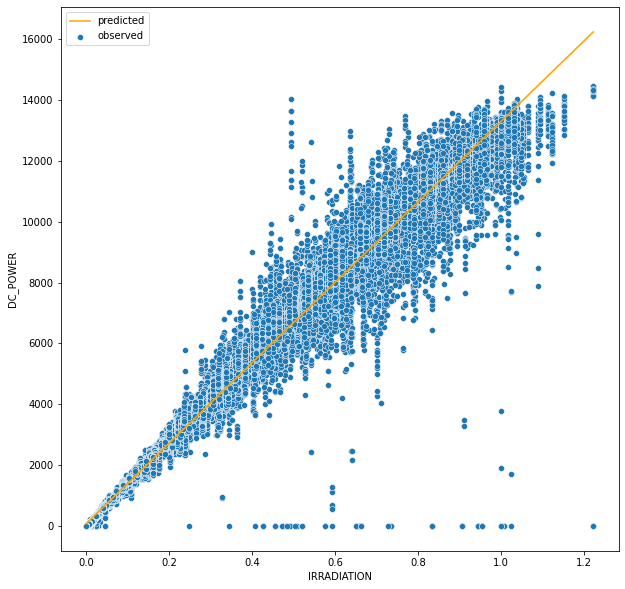

In [14]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="IRRADIATION", y="DC_POWER", label='observed', data=Plant_1)
sns.lineplot(x="IRRADIATION", y="DC_POWER_PREDICT", label='predicted', data=Plant_1, color='orange')
plt.show()

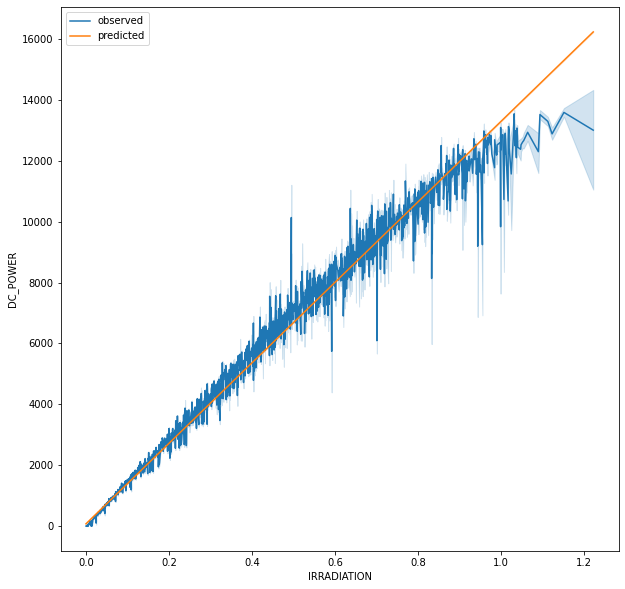

In [15]:
plt.figure(figsize=(10,10))
sns.lineplot(x="IRRADIATION", y="DC_POWER", label='observed', data=Plant_1)
sns.lineplot(x="IRRADIATION", y="DC_POWER_PREDICT", label='predicted', data=Plant_1)
plt.show()

La forme n'est pas mal, mais nous savons que quand il n'y a pas d'irradiation, il faut q'il n'y ait pas d'électricité génerée.
Cependent, la valeur de décalage n'est pas 0:

In [16]:
print(model.intercept_)

74.66409208708092


Nous voyons qu'il n y a aucune erreur systématique avec les capteurs - dans les données, chaque fois que l'irradiation est 0, l'électricité génerée est 0 aussi:

In [17]:
print(len(Plant_1.loc[Plant_1['IRRADIATION'] == 0]))
print(len(Plant_1.loc[(Plant_1['IRRADIATION'] == 0) & (Plant_1['DC_POWER'] != 0)]))

30398
0


Donc, il faut refaire l'analyse, cette fois avec une valeur de décalage fixée à 0.

In [18]:
model = LinearRegression(fit_intercept=False).fit(x, y)
r_sq = model.score(x, y)
print(r_sq)
print(model.coef_)
print(model.intercept_)

0.9786796942954222
[13345.70919172]
0.0


In [19]:
power_predict_2 = Plant_1['IRRADIATION']*model.coef_[0] + model.intercept_
power_predict_2 = [i for i in power_predict_2]

Plant_1['DC_POWER_PREDICT_ADJ'] = power_predict_2
Plant_1['DC_POWER_PREDICT_ADJ']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
68769    0.0
68770    0.0
68771    0.0
68772    0.0
68773    0.0
Name: DC_POWER_PREDICT_ADJ, Length: 68774, dtype: float64

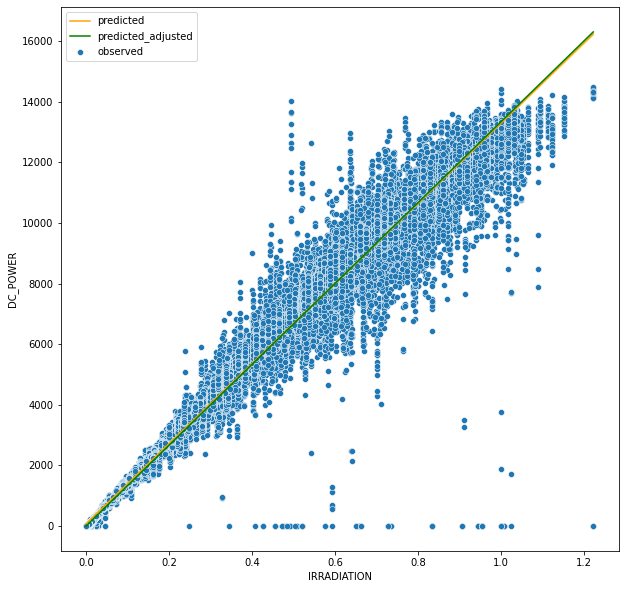

In [20]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="IRRADIATION", y="DC_POWER", label='observed', data=Plant_1)
sns.lineplot(x="IRRADIATION", y="DC_POWER_PREDICT", label='predicted', data=Plant_1, color='orange')
sns.lineplot(x="IRRADIATION", y="DC_POWER_PREDICT_ADJ", label='predicted_adjusted', data=Plant_1, color='green')
plt.show()

Grâce à cette intervention, nous pouvons automatiser l'identification d'erreurs en calculant l'électricité anticipée et identifier les points où il y a une deviation considérable entre les valeurs anticipées et réalisées.

In [21]:
Plant_1['DEVIATION'] = abs(Plant_1['DC_POWER_PREDICT_ADJ'] - Plant_1['DC_POWER'])

In [22]:
threshold = 0.6
Plant_1['MARGIN'] = threshold*Plant_1['DC_POWER_PREDICT_ADJ']

In [23]:
Plant_1

,DATE_TIME,PLANT_ID,INVERTER_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,WEATHER_SENSOR_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DC_POWER_PREDICT,DC_POWER_PREDICT_ADJ,DEVIATION,MARGIN
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15,00:00:00,74.664092,0.0,0.0,0.0
1,2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15,00:00:00,74.664092,0.0,0.0,0.0
2,2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15,00:00:00,74.664092,0.0,0.0,0.0
3,2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15,00:00:00,74.664092,0.0,0.0,0.0
4,2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15,00:00:00,74.664092,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68769,2020-06-17 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,2020-06-17,23:45:00,74.664092,0.0,0.0,0.0
68770,2020-06-17 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,2020-06-17,23:45:00,74.664092,0.0,0.0,0.0
68771,2020-06-17 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,2020-06-17,23:45:00,74.664092,0.0,0.0,0.0
68772,2020-06-17 23:45:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,2020-06-17,23:45:00,74.664092,0.0,0.0,0.0


In [24]:
Plant_1['ANOMALY'] = Plant_1.DEVIATION > Plant_1.MARGIN

In [25]:
Plant_1.loc[Plant_1['ANOMALY'] == True]

,DATE_TIME,PLANT_ID,INVERTER_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,WEATHER_SENSOR_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DC_POWER_PREDICT,DC_POWER_PREDICT_ADJ,DEVIATION,MARGIN,ANOMALY
489,2020-05-15 05:45:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,HmiyD2TTLFNqkNe,24.289211,23.096692,0.000863,2020-05-15,05:45:00,86.074618,11.513627,11.513627,6.908176,True
490,2020-05-15 05:45:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,HmiyD2TTLFNqkNe,24.289211,23.096692,0.000863,2020-05-15,05:45:00,86.074618,11.513627,11.513627,6.908176,True
491,2020-05-15 05:45:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,HmiyD2TTLFNqkNe,24.289211,23.096692,0.000863,2020-05-15,05:45:00,86.074618,11.513627,11.513627,6.908176,True
492,2020-05-15 05:45:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,HmiyD2TTLFNqkNe,24.289211,23.096692,0.000863,2020-05-15,05:45:00,86.074618,11.513627,11.513627,6.908176,True
493,2020-05-15 05:45:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,HmiyD2TTLFNqkNe,24.289211,23.096692,0.000863,2020-05-15,05:45:00,86.074618,11.513627,11.513627,6.908176,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68329,2020-06-17 18:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.0,7287002.0,HmiyD2TTLFNqkNe,23.583049,22.460372,0.000039,2020-06-17,18:45:00,75.181013,0.521592,0.521592,0.312955,True
68330,2020-06-17 18:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5883.0,7028601.0,HmiyD2TTLFNqkNe,23.583049,22.460372,0.000039,2020-06-17,18:45:00,75.181013,0.521592,0.521592,0.312955,True
68331,2020-06-17 18:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.0,7251204.0,HmiyD2TTLFNqkNe,23.583049,22.460372,0.000039,2020-06-17,18:45:00,75.181013,0.521592,0.521592,0.312955,True
68332,2020-06-17 18:45:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.0,6583369.0,HmiyD2TTLFNqkNe,23.583049,22.460372,0.000039,2020-06-17,18:45:00,75.181013,0.521592,0.521592,0.312955,True


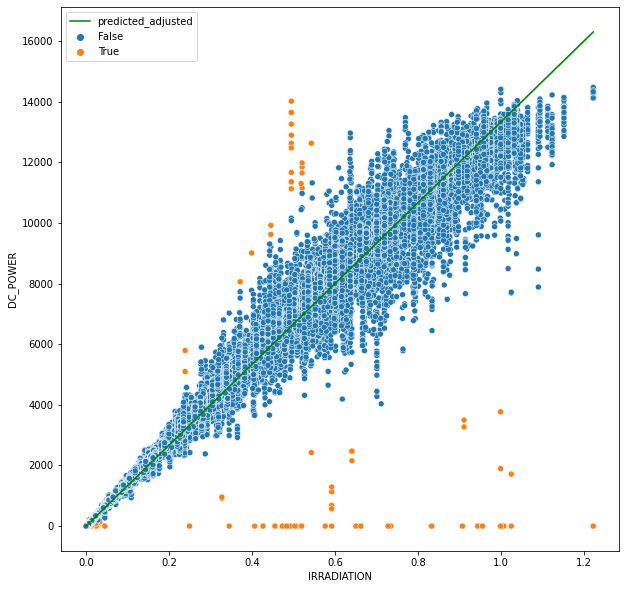

In [26]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="IRRADIATION", y="DC_POWER", data=Plant_1, hue='ANOMALY')
sns.lineplot(x="IRRADIATION", y="DC_POWER_PREDICT_ADJ", label='predicted_adjusted', data=Plant_1, color='green')
plt.show()